In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as image
import mplhep as hep
import os
import hist as hi
import numpy as np
hep.style.use([hep.style.ATLAS])
import sys
import datetime
import math
import struct
from pathlib import Path
sys.path.insert(1, 'C://Users//Peter//OneDrive - University of Cambridge//Desktop//summer2//Osiris Temp//processing//python')
import rawFileReader
import importlib
from scipy.optimize import curve_fit

In [5]:
class rpcHit():
    def __init__(self, channel, time, eta):
        self.time = time
        self.channel = channel
        self.eta = eta

def tdcChanToRPCHit(word,tdc):
    tdcChannel = (word>>24)&0x7f
    tdcHitTime = word&0xfffff
    eta = False
    rpcChan = -1
    if tdc==0:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 0
        elif tdcChannel<96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 0
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 1
    elif tdc==1:
        if tdcChannel<64:
            rpcChan = tdcChannel
            eta = False
            rpc = 1
        elif tdcChannel<96:
            rpcChan = tdcChannel-64
            eta = True
            rpc = 2
        else:
            rpcChan = tdcChannel-96
            eta = False
            rpc = 2
    elif tdc==2:
        if tdcChannel<32:
            rpcChan = tdcChannel+32
            eta = False
            rpc = 2
        elif tdcChannel<64:
            rpcChan = tdcChannel-32
            eta = True
            rpc = 3
        elif tdcChannel<128:
            rpcChan = tdcChannel-64
            eta = False
            rpc = 3
    elif tdc==3:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 4
        elif tdcChannel<96:
            rpcChan = tdcChannel-32
            eta = False
            rpc = 4
        else:
            rpcChan = tdcChannel-96
            eta = True
            rpc = 5
    elif tdc==4:
        rpcChan = tdcChannel
        eta = False
        rpc = 5
    return rpc, rpcHit(rpcChan,tdcHitTime*0.8,eta)

In [6]:
def tdcEventToRPCData(event,activeTDCs=[0,1,2,3,4]):
    rpcHits = [[] for rpc in range(6)]
    for tdc in activeTDCs:
        for word in event.tdcEvents[tdc].words:
            rpc, thisHit = tdcChanToRPCHit(word,tdc)
            rpcHits[rpc].append(thisHit)
    return rpcHits

In [7]:
allFpaths = []
for dirname in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'):
    for file in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname):
        if 'sys' not in file:
            if 'raw' in file:
                allFpaths.append('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname+'/'+file)

In [7]:
def readTDCTimeDiffs(filename):
    totDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],3:[[0 for etchan in range(32)] for phchan in range(64)],4:[[0 for etchan in range(32)] for phchan in range(64)]}
    nDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],3:[[0 for etchan in range(32)] for phchan in range(64)],4:[[0 for etchan in range(32)] for phchan in range(64)]}
    diffHists = {0:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc0etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                 3:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc2etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                 4:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc3etPhiDiff")) for etchan in range(32)] for phchan in range(64)]}

    importlib.reload(rawFileReader)
    fReader = rawFileReader.fileReader(filename)
    processedEvents = 0
    while fReader.readBlock():
        if(fReader.hasEvents()):
            for event in fReader.getEvents():
                processedEvents = processedEvents+1
                if processedEvents%100000==0:
                    print("Processed",processedEvents,"Events")
                rpcHits = tdcEventToRPCData(event,activeTDCs=[0,2,3])
                for rpc in [0,3,4]:
                    minEtaHit = rpcHit(-1,1000,True)
                    minPhiHit = rpcHit(-1,1000,False)
                    for hit in rpcHits[rpc]:
                        if hit.time>150 and hit.time<300:
                            if hit.eta and hit.time<minEtaHit.time:
                                minEtaHit = hit
                            elif hit.time<minPhiHit.time and not hit.eta:
                                minPhiHit = hit
                    if minEtaHit.channel>-0.5 and minPhiHit.channel>-0.5:
                        totDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = totDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+minEtaHit.time-minPhiHit.time
                        nDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = nDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+1
                        diffHists[rpc][minPhiHit.channel][minEtaHit.channel].fill(minEtaHit.time-minPhiHit.time)
    outDict = {'totDiffs':totDiffs,
               'nDiffs':nDiffs,
               'diffHists':diffHists}
    return outDict

In [9]:
readDict = readTDCTimeDiffs('..//Data//Old//Beam2.raw')

Processed 100000 Events
Processed 200000 Events
Processed 300000 Events
Processed 400000 Events
Processed 500000 Events
Processed 600000 Events
Processed 700000 Events
Processed 800000 Events
Processed 900000 Events
Processed 1000000 Events
Processed 1100000 Events
Processed 1200000 Events
Processed 1300000 Events
Processed 1400000 Events
Processed 1500000 Events
Processed 1600000 Events
Processed 1700000 Events
Processed 1800000 Events
Processed 1900000 Events
Processed 2000000 Events
Processed 2100000 Events
Processed 2200000 Events
Processed 2300000 Events
Processed 2400000 Events
Processed 2500000 Events
Processed 2600000 Events
Processed 2700000 Events
Processed 2800000 Events
Processed 2900000 Events
Processed 3000000 Events
Processed 3100000 Events
Processed 3200000 Events
Processed 3300000 Events
Processed 3400000 Events
Processed 3500000 Events
Processed 3600000 Events
Processed 3700000 Events
Processed 3800000 Events
Processed 3900000 Events
Processed 4000000 Events
Processed

KeyboardInterrupt: 

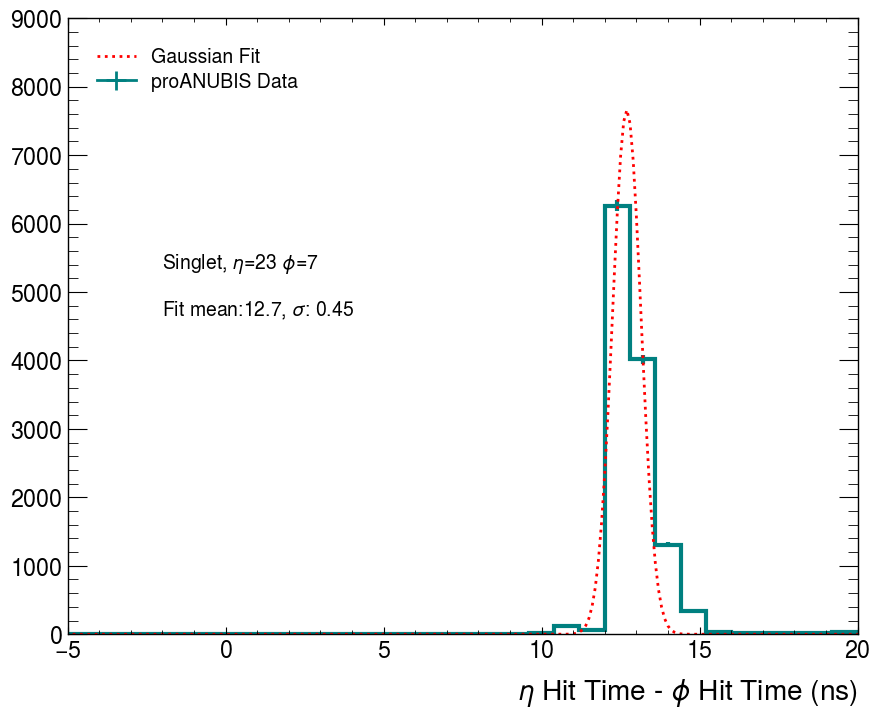

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
ph = 7
et = 23
rpc= 3
rpcTitles = {0:'Triplet Low',3:'Singlet',4:'Doublet Low'}
readDict['diffHists'][rpc][ph][et].plot1d(ax=ax, color="teal", lw=3, label='proANUBIS Data')

ax.set_xlabel('$\eta$ Hit Time - $\phi$ Hit Time (ns)')
yrange = ax.get_ylim()
ax.text(-2, 0.8*yrange[1], rpcTitles[rpc]+", $\eta$="+str(et)+" $\phi$="+str(ph), fontsize=14,
                verticalalignment='top')
#ax.set_yscale('log')

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,readDict['diffHists'][rpc][ph][et].axes.centers[0],readDict['diffHists'][rpc][ph][et].values(),p0=[1,13,5])
fitX = [0.1*x-10 for x in range(400)]
plt.plot(fitX,gaus(fitX,*popt),'r:',label='Gaussian Fit')
ax.set_xlim([-5,20])
ax.text(-2, 0.7*yrange[1], "Fit mean:"+str(round(popt[1],2))+", $\sigma$: "+str(round(popt[2],2)), fontsize=14,
                verticalalignment='top')
plt.legend()
plt.show()

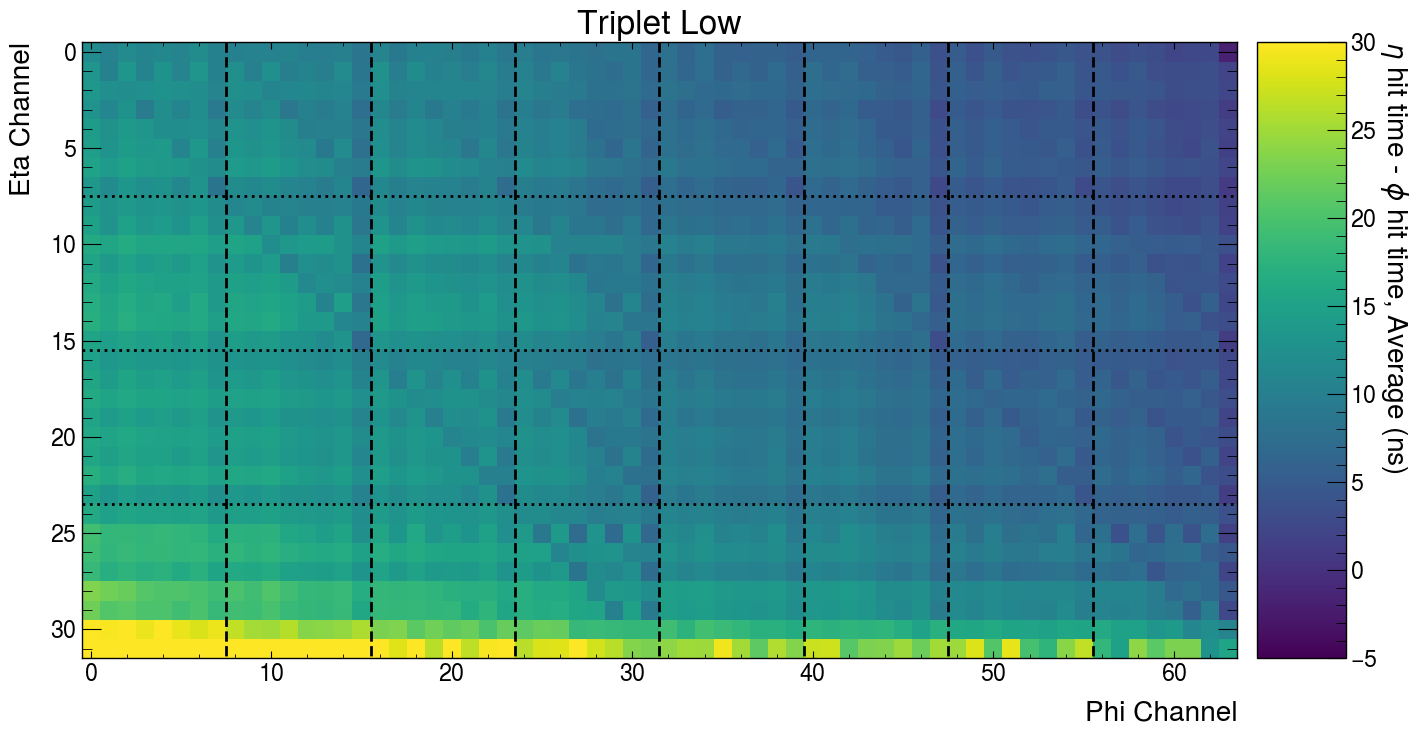

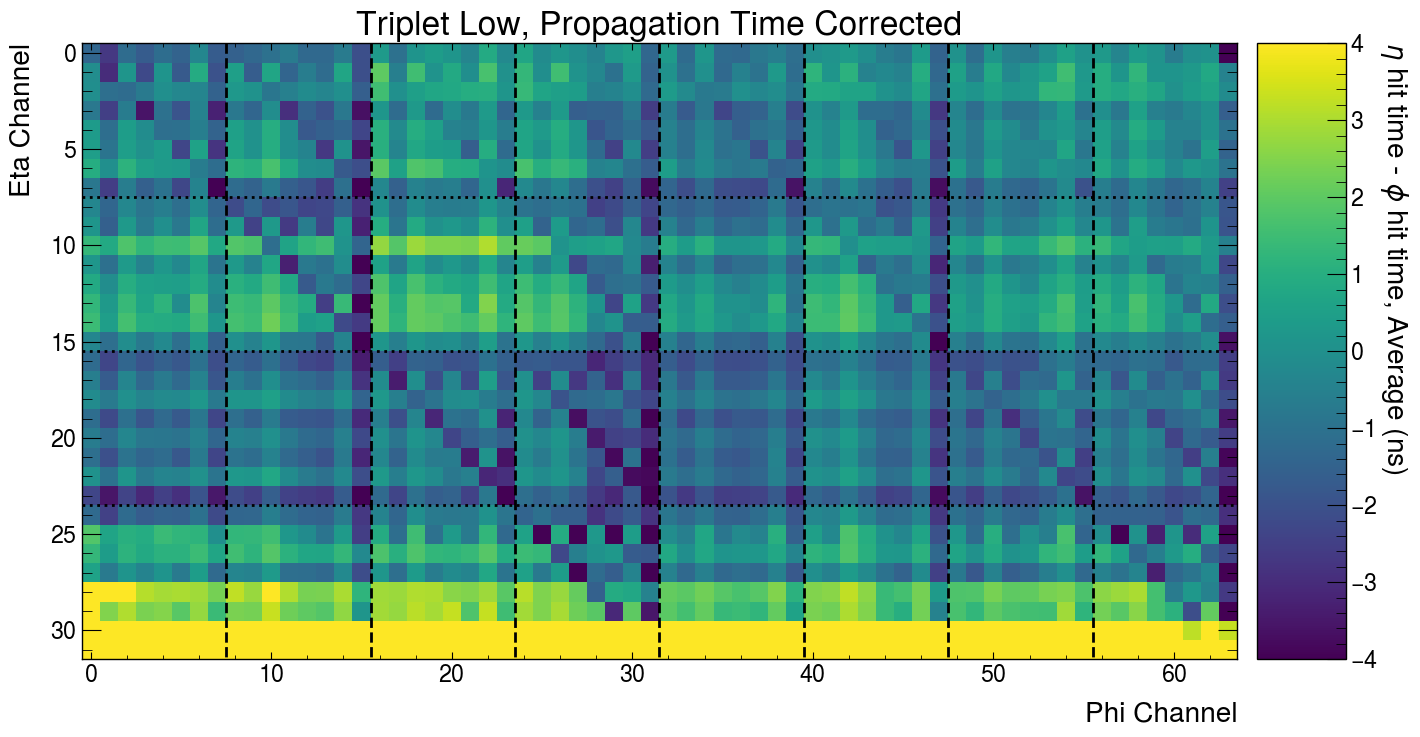

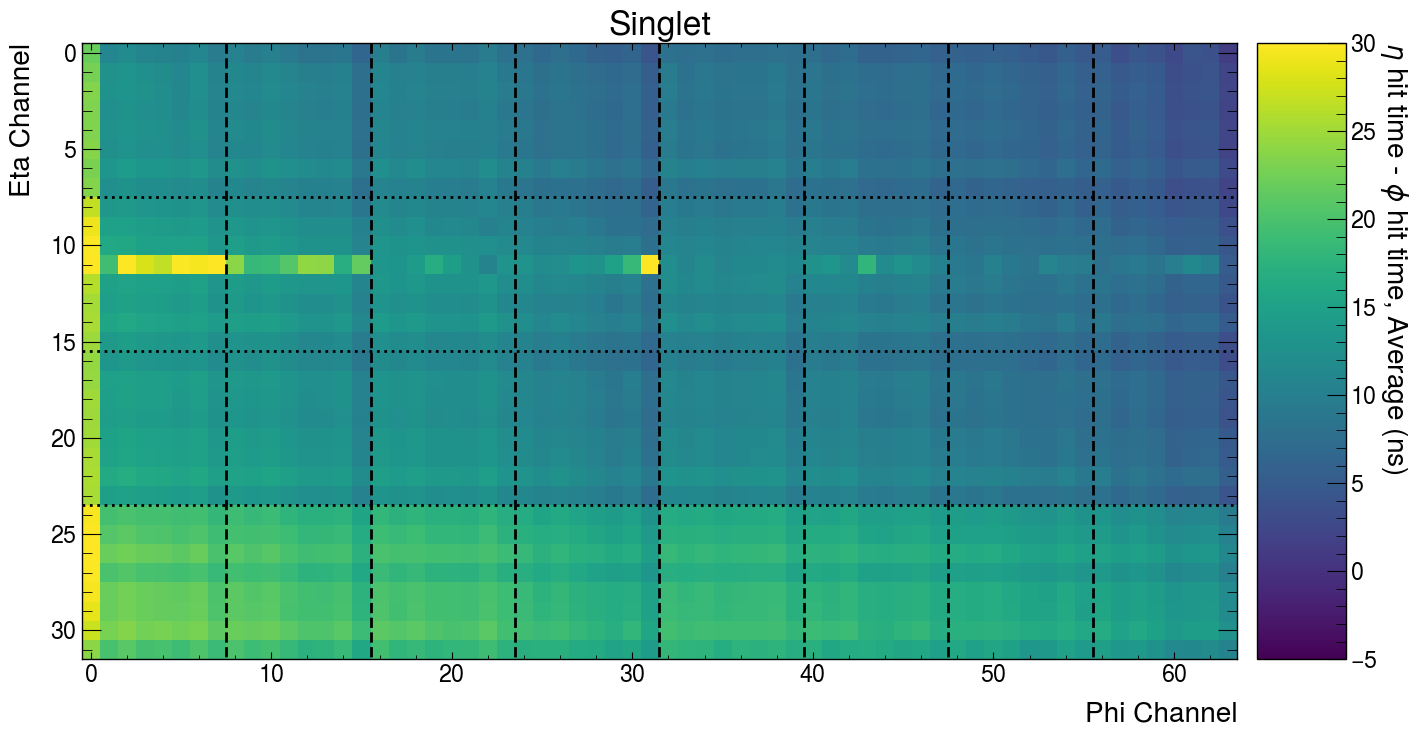

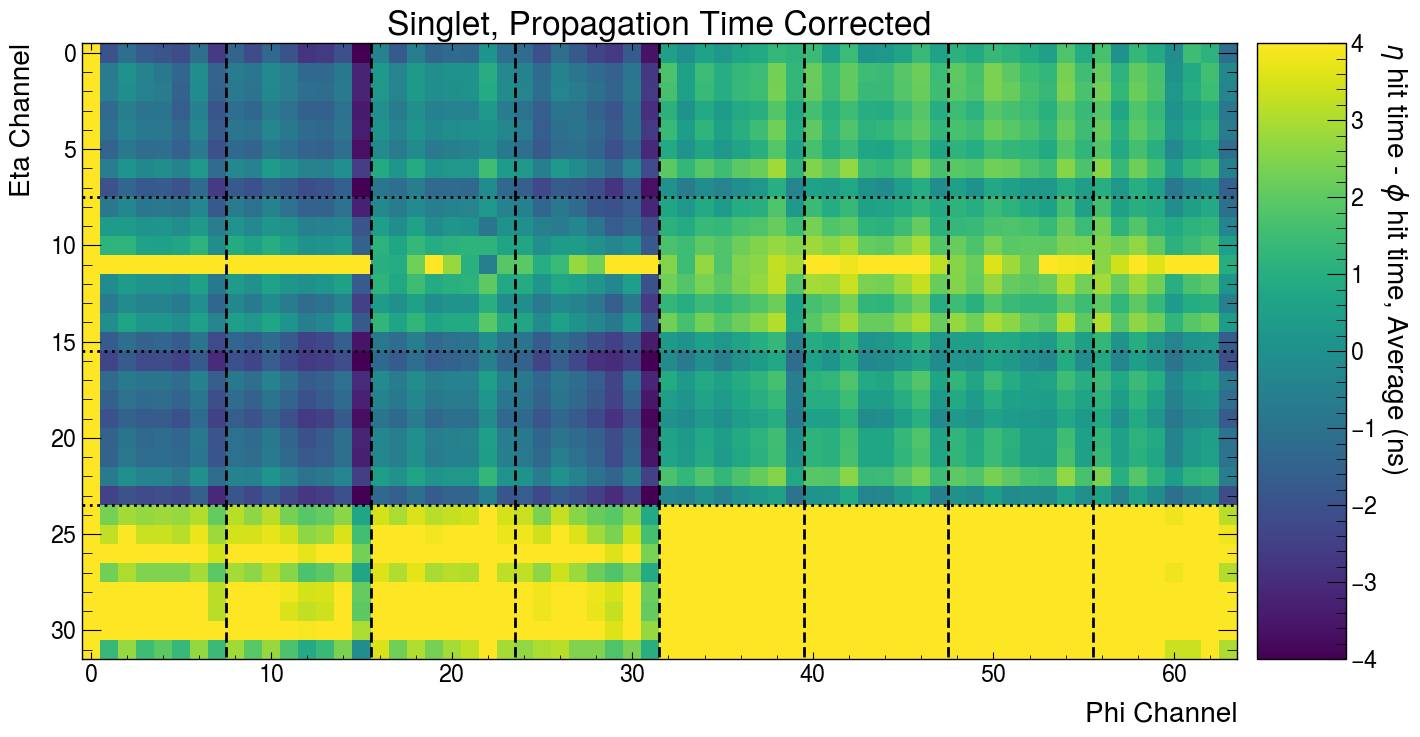

/tmp/ipykernel_1175/3239918404.py:15: RuntimeWarning: invalid value encountered in double_scalars
  scDiffs[ph][et]=sum([thisVal*readDict['diffHists'][rpc][ph][et].axes.centers[0][idx] for idx, thisVal in enumerate(readDict['diffHists'][rpc][ph][et])])/sum(readDict['diffHists'][rpc][ph][et].counts())


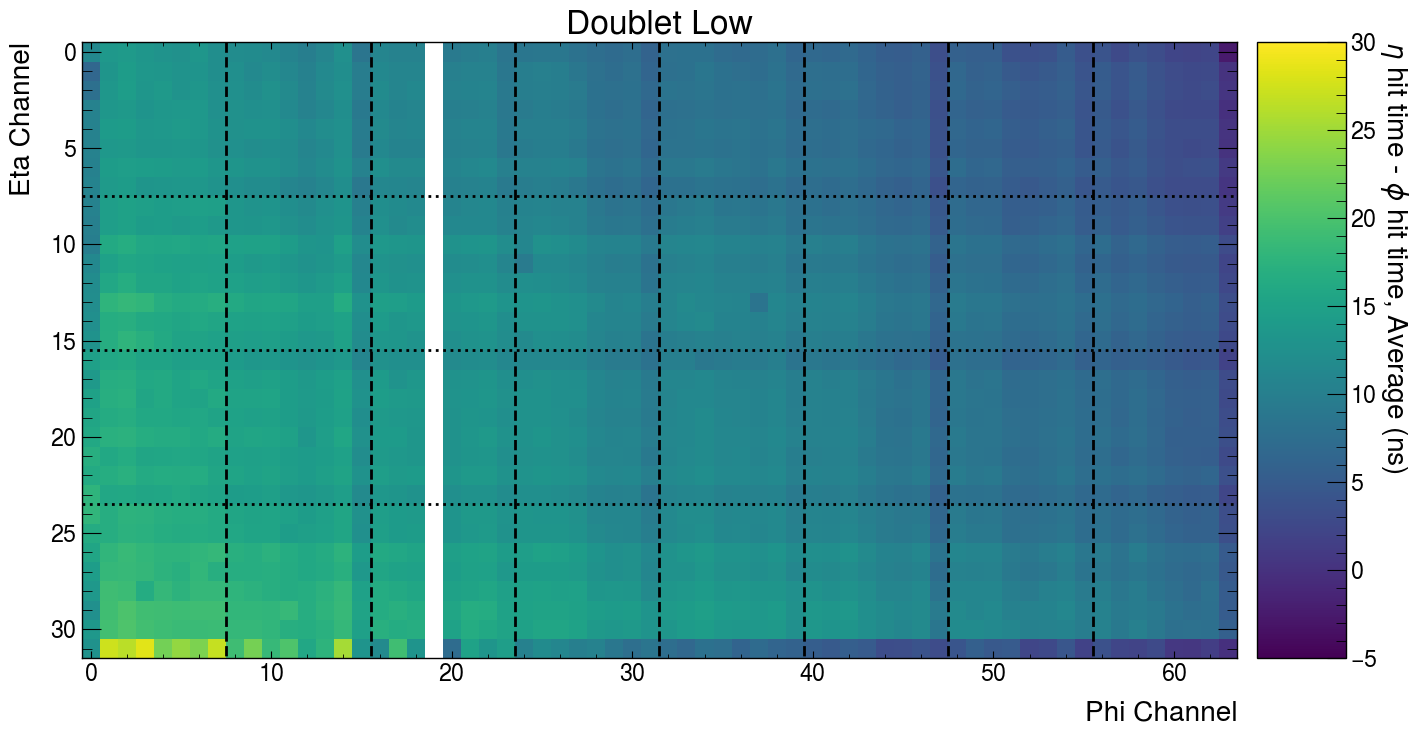

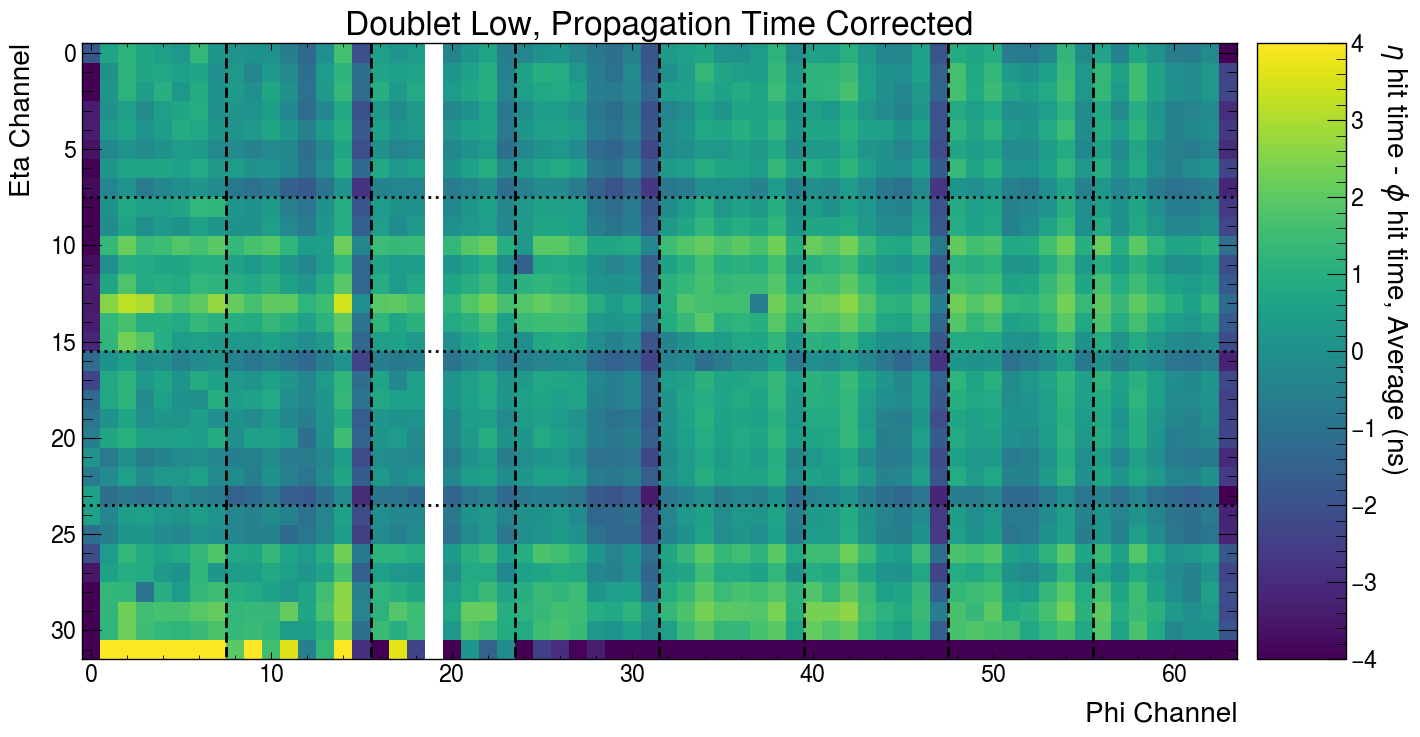

In [32]:
scDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
normDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
badPhi = {0:[],3:[0],4:[0,19]}
badEta = {0:[24,25,26,27,28,29,30,31],3:[11],4:[31]}
residEtaLatest = []
residPhiLatest = []
rpcNames = {0:"Triplet Low",3:"Singlet",4:"Doublet Low"}
evtCount = 0
for rpc in [0,3,4]:
    slope = 0.173
    offSet = 13.2
    for ph in range(64):
        for et in range(32):
            if sum(readDict['diffHists'][rpc][ph][et].counts())>0:
                scDiffs[ph][et]=sum([thisVal*readDict['diffHists'][rpc][ph][et].axes.centers[0][idx] for idx, thisVal in enumerate(readDict['diffHists'][rpc][ph][et])])/sum(readDict['diffHists'][rpc][ph][et].counts())
                normDiffs[ph][et]=scDiffs[ph][et]+slope*(ph-et)-offSet

    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    etachannels = [x-0.5 for x in range(33)]
    phichannels = [x-0.5 for x in range(65)]
    etaHist = (scDiffs,np.array(phichannels),np.array(etachannels))
    zrange = [-5,30]
    thisHist = hep.hist2dplot(etaHist,norm=colors.Normalize(zrange[0],zrange[1]))
    thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
    plt.ylim(31.5,-0.5)
    plt.ylabel("Eta Channel")
    plt.xlabel("Phi Channel")
    ax.set_title(rpcNames[rpc])
    x_points = [-0.5, 64.5]
    y_points = [7.5, 15.5, 23.5]
    for y_point in y_points:
        plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
    y_points = [-0.5, 31.5]
    x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
    for x_point in x_points:
        plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
    plt.show()
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    normHist = (normDiffs,np.array(phichannels),np.array(etachannels))
    zrange = [-4,4]
    thisHist = hep.hist2dplot(normHist,norm=colors.Normalize(zrange[0],zrange[1]))
    thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
    plt.ylim(31.5,-0.5)
    plt.ylabel("Eta Channel")
    plt.xlabel("Phi Channel")

    x_points = [-0.5, 64.5]
    y_points = [7.5, 15.5, 23.5]
    for y_point in y_points:
        plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
    y_points = [-0.5, 31.5]
    x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
    for x_point in x_points:
        plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
    ax.set_title(rpcNames[rpc]+", Propagation Time Corrected")
    plt.show()
    phTimes = [0 for chan in range(64)]
    etTimes = [0 for chan in range(32)]
    testSpeed = 0.173
    offSet = 13.46
    for phchan in range(64):
        for etchan in range(32):
            if etchan not in badEta[rpc]:
                phTimes[phchan] = phTimes[phchan]+scDiffs[phchan][etchan]-etchan*testSpeed+phchan*testSpeed-offSet
        phTimes[phchan] = phTimes[phchan]/(32.-len(badEta[rpc]))
    for phchan in range(64):
        for etchan in range(32):
            if phchan not in badPhi[rpc]:
                etTimes[etchan] = etTimes[etchan]+(scDiffs[phchan][etchan]+phchan*testSpeed-etchan*testSpeed-offSet-phTimes[phchan])/(64.-len(badPhi[rpc]))
    residEtaLatest.append([time for time in etTimes])
    residPhiLatest.append([time for time in phTimes])

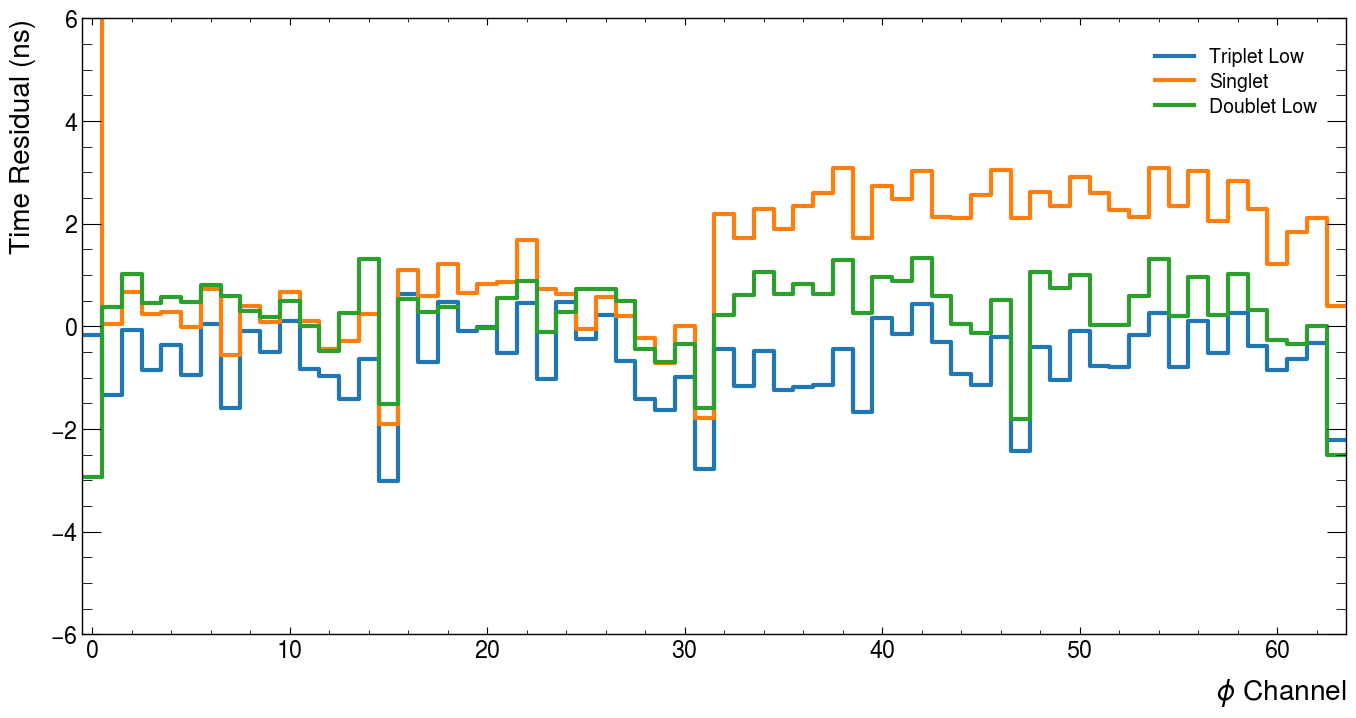

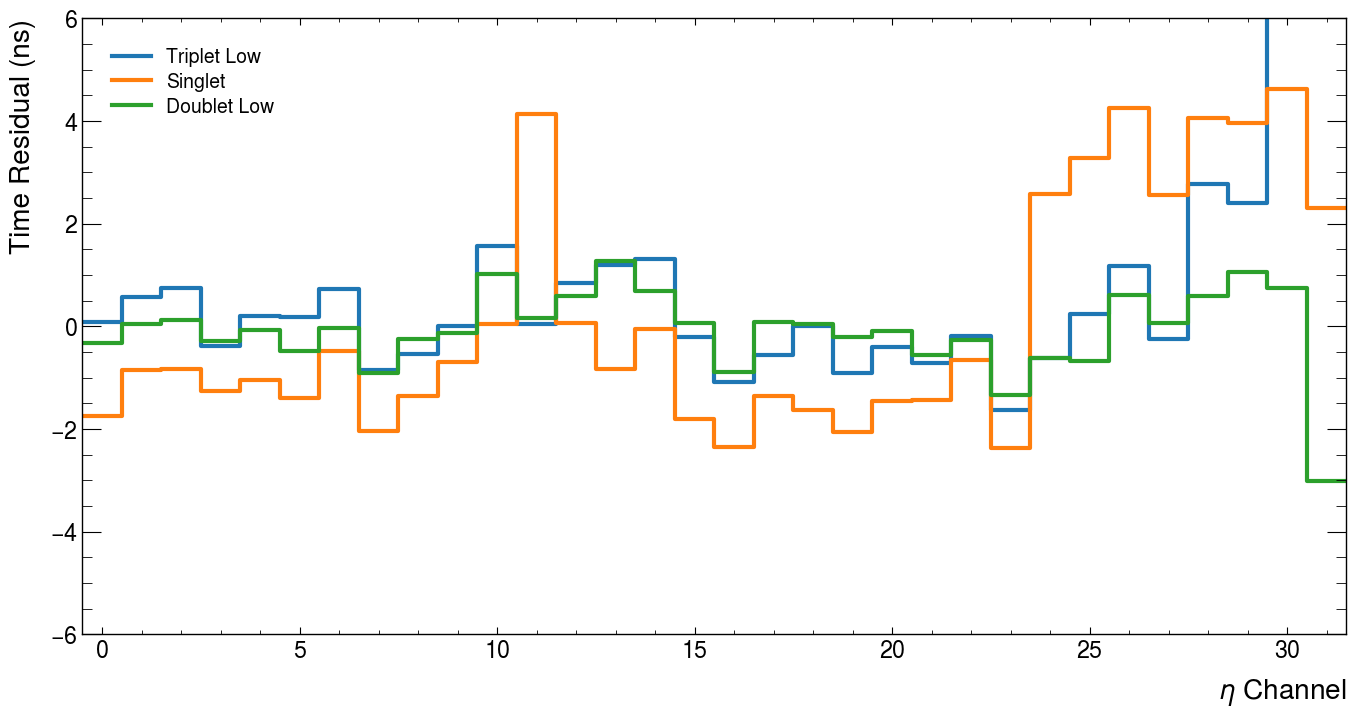

In [43]:
fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
phichannels = [x-0.5 for x in range(65)]

for idx, rpc in enumerate([0,3,4]):
    plotPhiResids = residPhiLatest[idx].copy()
    plotPhiResids.append(plotPhiResids[-1])
    plt.step(phichannels,plotPhiResids,linewidth=3,label=rpcNames[rpc],where='post')
yrange = ax.get_ylim()
#ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
 #               verticalalignment='top')
ax.set_xlabel('$\phi$ Channel')
ax.set_ylabel('Time Residual (ns)')
ax.set_ylim([-6,6])
ax.set_xlim([-0.5,63.5])
plt.legend()
plt.show()
fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
etchannels = [x-0.5 for x in range(33)]
for idx, rpc in enumerate([0,3,4]):
    plotEtaResids = residEtaLatest[idx].copy()
    plotEtaResids.append(plotEtaResids[-1])
    plt.step(etchannels,plotEtaResids,linewidth=3,label=rpcNames[rpc],where='post')
yrange = ax.get_ylim()
#ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
 #               verticalalignment='top')
ax.set_xlabel('$\eta$ Channel')
ax.set_ylabel('Time Residual (ns)')
ax.set_ylim([-6,6])
ax.set_xlim([-0.5,31.5])
plt.legend()
plt.show()

0.17386500641569963 13.456514297841695


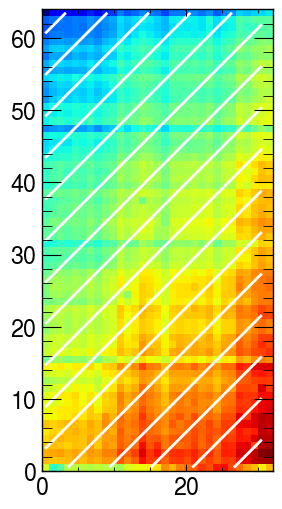

In [46]:
excludedEta = [31]
excludedPhi = [19]
fitPhChan = [0.5+chan for chan in range(64)]
fitEtChan = [0.5+chan for chan in range(32)]
fitDiffs = [row[:] for row in scDiffs]

for phchan in range(64):
    for etchan in range(32):
        if phchan in excludedPhi:
            fitDiffs[phchan][etchan] = scDiffs[phchan+1][etchan]
        if etchan in excludedEta:
            fitDiffs[phchan].pop(etchan)

for etChan in excludedEta:
    fitEtChan.pop(etChan)

def plane(xy,a,b):
    x, y = xy
    return (a*(x-y)+b).ravel()

x, y = np.meshgrid(fitEtChan, fitPhChan)

popt,pcov = curve_fit(plane,(x,y),np.array(fitDiffs).ravel(),p0=[0.175,13])
print(popt[0],popt[1])
data_fitted = plane((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(np.array(fitDiffs).ravel().reshape(64, 31), cmap=plt.cm.jet, origin='lower',
    extent=(0, 32, 0, 64))
ax.contour(x, y, data_fitted.reshape(64, 31), 16, colors='w')
plt.show()